In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly_resampler import (
    register_plotly_resampler,
    FigureWidgetResampler,
    FigureResampler,
)
import IPython.display as ipd

# register_plotly_resampler(mode="widget")

In [2]:
def spline(y1: float, k1: float, y2: float, k2: float, t: float) -> float:
    r = 1.0 - t
    d = y2 - y1
    return r * y1 + t * y2 + t * r * (r * (k1 - d) + t * (d - k2))


def this_blep_sample(t: float) -> float:
    return 0.5 * t * t


def next_blep_sample(t: float) -> float:
    t = 1 - t
    return -0.5 * t * t


def next_integrated_blep_sample(t: float) -> float:
    t1 = 0.5 * t
    t2 = t1 * t1
    t4 = t2 * t2
    return 0.1875 - t1 + 1.5 * t2 - t4


def this_integrated_blep_sample(t: float) -> float:
    return next_integrated_blep_sample(1 - t)


def polyblep(t: float, dt: float) -> float:
    if t < dt:
        # t /= dt
        # return t + t - t * t - 1
        t = t / dt - 1
        return -t * t
    elif t > 1 - dt:
        t = (t - 1) / dt + 1
        return t * t
        # t = (t - 1) / dt
        # return t * t + t + t + 1
    return 0


def polyblamp(t: float, dt: float) -> float:
    if t < dt:
        t = t / dt - 1
        return (-1 / 3) * t * t * t
    elif t > 1 - dt:
        t = (t - 1) / dt + 1
        return (1 / 3) * t * t * t
    return 0


def tri(t: float, dt: float, shape: float) -> float:
    t = (t + (shape / 2) - 0.5) % 1
    if t < shape:
        v = 1 - 2 * t / shape
    else:
        v = 2 * (t - shape) / (1 - shape) - 1

    up_slope = 1 / shape
    down_slope = -1 / (1 - shape)
    t2 = t
    v += (down_slope - up_slope) * dt * polyblamp(t2, dt)
    t2 += 1 - shape
    t2 %= 1
    v += (up_slope - down_slope) * dt * polyblamp(t2, dt)
    return v

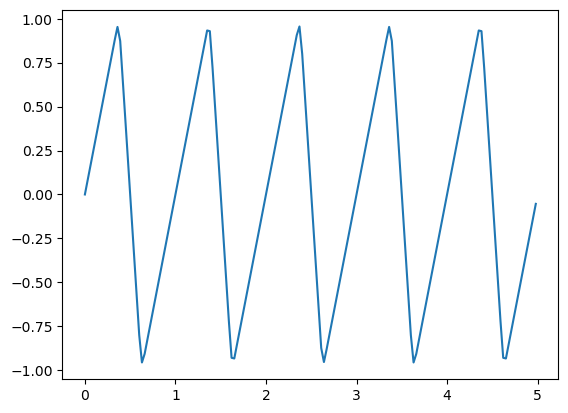

In [3]:
dt = 0.03
t = np.arange(0, 5, dt)
plt.plot(t, np.array([tri(t % 1, dt, 0.25) for t in t]))

In [23]:
def crossfade(a: float, b: float, fade: float) -> float:
    return a + (b - a) * fade


def spline_lfo(
    attack: float,
    pw1: float,
    release: float,
    up_slope: float,
    down_slope: float,
    p: float,
) -> float:
    if p == 0:
        return -1
    if p <= attack:
        p = p / attack
        return spline(-1, up_slope, 1, up_slope, p)
    p -= attack
    if p <= pw1:
        return 1
    p -= pw1
    if p <= release:
        p = p / release
        return spline(1, down_slope, -1, down_slope, p)
    p -= release
    return -1


def spline_polyblep_osc(
    attack: float,
    pw1: float,
    release: float,
    up_slope: float,
    down_slope: float,
    p: float,
    dp: float,
    discontinuity_threshold: float = 0.2,
) -> float:
    has_rise = attack > 0.5 * dp
    has_fall = release > 0.5 * dp
    # has_rise = attack > 2 / 31250
    # has_fall = release > 2 / 31250
    correction = 0

    # There are four potential places of discontinuity in the first derivative:
    # 1. Beginning of attack
    # 2. End of attack
    # 3. Beginning of release
    # 4. End of release
    # Normally, with blamp, you add the up slope and subtract the (negative)
    # down slope at the same spot. Here, they can be separated by a plateau.
    # However, that only ends up changing where they're applied, not how they're
    # applied, so we can generalize by treating each spot separately.

    # beginning of attack:
    if has_rise:
        # up_slope is relative to attack time, ranging from 0 (for approx sine
        # curve) to 1 (for variable slope triangle). up_slope / attack thus
        # gives the true slope at the beginning and end of attack. If up_slope=0
        # then there's (probably) no discontinuity in the first derivative, so
        # it correctly cancels out.
        # minus because we're going from flat (or fall) to rise
        correction += up_slope / attack * dp * polyblamp(p, dp)
        # handle end of attack
        correction -= up_slope / attack * dp * polyblamp((p - attack + 1) % 1, dp)
    else:
        # no attack, so we have a value discontinuity and so use polyblep
        correction += polyblep(p, dp)
    if has_fall:
        # beginning of release
        correction -= (
            -down_slope / release * dp * polyblamp((p - attack - pw1 + 1) % 1, dp)
        )
        # end of release
        correction += (
            -down_slope
            / release
            * dp
            * polyblamp((p - attack - pw1 - release + 1) % 1, dp)
        )
    else:
        correction -= polyblep((p - attack - pw1 + 1) % 1, dp)

    # if release < 0.2 * dp:
    #     blep = -polyblep((p + 0.5) % 1, dp)
    if p <= attack + pw1:
        if p >= attack:
            value = 1.0
        else:
            p /= attack
            value = spline(-1, up_slope, 1, up_slope, p)
    else:
        p -= attack + pw1
        if p >= release:
            value = -1
        else:
            p /= release
            value = spline(1, down_slope, -1, down_slope, p)
    return value + correction


def shape_polyblep(shape: float, p: float, dp: float, apply_blep: bool = True) -> float:
    if shape > 0.5:
        value = 1 if p < 0.5 else -1
        if apply_blep:
            value += polyblep(p, dp)
            value -= polyblep((p + 0.5) % 1, dp)
        return value
    else:
        value = 1 - 2 * p
        if apply_blep:
            value += polyblep(p, dp)
        return value


def shape_spline_bp_osc(shape: float, p: float, dp: float) -> float:
    ramp_boundary = 0.333
    trap_boundary = 0.667
    if shape <= ramp_boundary:
        attack = shape / (2 * ramp_boundary)
        pw1 = 0
        release = 1 - attack
        up_slope = 2
        down_slope = -2
    elif shape <= trap_boundary:
        attack = 0.5
        pw1 = 0
        release = 0.5
        up_slope = 2 * abs(shape - 0.5) / (0.5 - ramp_boundary)
        down_slope = -up_slope
    else:
        pw = (shape - trap_boundary) / (1 - trap_boundary)
        attack = (1 - pw) * 0.5
        pw1 = pw * 0.5
        release = attack
        up_slope = 2
        down_slope = -up_slope
    return spline_polyblep_osc(attack, pw1, release, up_slope, down_slope, p, dp)
    # return spline_lfo(attack, pw1, release, up_slope, down_slope, p)


def shape_spline_osc(shape: float, p: float, dp: float) -> float:
    ramp_boundary = 0.333
    trap_boundary = 0.667
    if shape <= ramp_boundary:
        attack = shape / (2 * ramp_boundary)
        pw1 = 0
        release = 1 - attack
        up_slope = 2
        down_slope = -2
    elif shape <= trap_boundary:
        attack = 0.5
        pw1 = 0
        release = 0.5
        up_slope = 2 * abs(shape - 0.5) / (0.5 - ramp_boundary)
        down_slope = -up_slope
    else:
        pw = (shape - trap_boundary) / (1 - trap_boundary)
        attack = (1 - pw) * 0.5
        pw1 = pw * 0.5
        release = attack
        up_slope = 2
        down_slope = -up_slope
    if attack < 2 * dp:
        up_slope *= attack / (2 * dp)
        attack = 2 * dp
        if pw1 > 2 * dp:
            pw1 -= 2 * dp
        else:
            release -= 2 * dp
    if release < 2 * dp:
        down_slope *= release / (2 * dp)
        release = 2 * dp

    return spline_lfo(attack, pw1, release, up_slope, down_slope, p)


def shape_spline_lfo(
    shape: float, p: float, min_transition: float = 0, trans_sharp: float = 0
) -> float:
    ramp_boundary = 0.333
    trap_boundary = 0.667
    if shape <= ramp_boundary:
        attack = max(shape / (2 * ramp_boundary), min_transition)
        pw1 = 0
        release = 1 - attack
        up_slope = 2 if attack > min_transition else trans_sharp
        down_slope = -2
    elif shape <= trap_boundary:
        attack = 0.5
        pw1 = 0
        release = 0.5
        up_slope = 2 * abs(shape - 0.5) / (0.5 - ramp_boundary)
        down_slope = -up_slope
    else:
        pw = (shape - trap_boundary) / (1 - trap_boundary)
        attack = max((1 - pw) * 0.5, min_transition)
        pw1 = pw * 0.5
        release = attack
        up_slope = 2 if attack > min_transition else trans_sharp
        down_slope = -up_slope
    return spline_lfo(attack, pw1, release, up_slope, down_slope, p)


def shape_lfo(shape: float, p: float) -> float:
    shape -= 0.5
    shape = 2 + 9.999999 * shape / (1 + 3 * abs(shape))
    slope = min(shape * 0.5, 0.5)
    plateau_width = max(shape - 3, 0)
    sine_amount = max((shape - 1) if shape < 2 else (3 - shape), 0)

    slope_up = 1 / slope
    slope_down = 1 / (1 - slope)
    plateau = 0.5 * (1 - plateau_width)
    normalization = 1 / plateau
    phase_shift = plateau_width * 0.25

    # print(locals())

    p = p + phase_shift
    if p > 1:
        p -= 1
    triangle = slope_up * p if p < slope else 1 - (p - slope) * slope_down
    triangle -= 0.5
    triangle = min(max(triangle, -plateau), plateau)
    triangle *= normalization
    sine = np.sin((2 * np.pi * (p + 0.75)))
    return crossfade(triangle, sine, sine_amount)


# plt.plot(xs, [shape_lfo(0.4, x % 1) for x in xs])
# plt.plot(xs, [shape_lfo(0.6, x % 1) for x in xs])
# plt.plot(xs, [shape_spline_lfo(0.6, x % 1) for x in xs])
# xs = np.linspace(0.4999999, 0.5000001, 1000)
# for s in np.linspace(0.64285715, 0.6428572, 5):
#     plt.plot(xs, [shape_lfo(s, x % 1) for x in xs], label=s)
#     plt.legend()
# plt.figure()
# for s in np.linspace(0.67, 1, 3):
#     plt.plot(xs, [shape_spline_lfo(s, x % 1) for x in xs], label=s)
#     plt.legend()
# shape_lfo(0.64285, 0.5)

In [24]:
# sample_rate = 31250

duration = 10
shape = 0.5
frequency = 10
sample_rate = 31250

xs = np.linspace(0, duration, int(sample_rate * duration))
ys = np.array([shape_lfo(shape, (frequency * x) % 1) for x in xs])
# fig = go.FigureWidget(make_subplots(rows=1, cols=2))
fig = FigureWidgetResampler(make_subplots(rows=1, cols=2))
# fig = go.FigureWidget()
fig.add_trace(
    go.Scattergl(mode="lines"),
    hf_x=xs,
    hf_y=ys,
    row=1,
    col=1,
)
fig.add_trace(
    go.Scattergl(mode="lines"),
    hf_x=xs,
    hf_y=ys,
    row=1,
    col=2,
)
fig.update_yaxes(row=1, col=2, range=[-9, 0])
# fig.add_trace(go.Scattergl(mode="lines", x=xs, y=ys))
# fig.add_trace(go.Scattergl(x=[], y=[], mode="lines"), row=1, col=2)


# @widgets.interact
def plot_lfo(
    shape: float,
    frequency: float,
    duration: float,
    sample_rate: int = 31250,
    resolution: int = 31250,
    osc: str = "spline",
    logscale: bool = True,
    trans: float = 0,
    trans_sharp: float = 0,
):
    global xs, ys
    # duration = periods / frequency
    with fig.batch_update():
        duration = np.ceil(duration * frequency) / frequency
        xs = np.linspace(0, duration, int(resolution * duration))
        print(len(xs))
        if osc == "spline":
            ys = np.array(
                [
                    shape_spline_lfo(
                        shape,
                        (frequency * x) % 1,
                        # min_transition=trans * frequency / sample_rate,
                        # trans_sharp=trans_sharp,
                    )
                    for x in xs
                ]
            )
        elif osc == "orig":
            ys = np.array([shape_lfo(shape, (frequency * x) % 1) for x in xs])
        elif osc == "polyblep":
            ys = np.array(
                [
                    shape_polyblep(
                        shape, (frequency * x) % 1, frequency / sample_rate, trans > 0.5
                    )
                    for x in xs
                ]
            )
        elif osc == "spline_polyblep":
            ys = np.array(
                [
                    shape_spline_osc(
                        # abs(x % 2 - 1),
                        shape,
                        (frequency * x) % 1,
                        frequency / sample_rate,
                    )
                    for x in xs
                ]
            )
        elif osc == "tri":
            ys = np.array(
                [tri((frequency * x) % 1, frequency / sample_rate, shape) for x in xs]
            )
        print(len(ys))

        fig.hf_data[0]["x"] = xs
        fig.hf_data[0]["y"] = ys
        fft_ys = np.fft.rfft(ys)
        freqs = np.fft.rfftfreq(len(ys), d=1 / resolution)
        fig.update_yaxes(type="log" if logscale else "linear", row=1, col=2)
        fig.hf_data[1]["x"] = freqs
        fig.hf_data[1]["y"] = np.abs(fft_ys) / resolution
        # fig.data[0].y = ys  # type: ignore
        # fig.data[0].x = xs
    fig.reload_data()
    display(ipd.Audio(ys, rate=resolution, autoplay=True))


widgets.interact(
    plot_lfo,
    shape=widgets.FloatSlider(value=0.5, min=0, max=1.0, step=0.01),
    # frequency=widgets.FloatLogSlider(min=0, max=16, base=2.0),
    frequency=widgets.FloatText(value=1960.0),
    duration=widgets.FloatSlider(value=1.0, min=0.01, max=10.0, step=0.01),
    # duration=widgets.FloatText(value=1.0, min=0.01, max=10.0, step=0.01),
    sample_rate=widgets.IntSlider(value=31250, min=16000, max=96000, step=50),
    resolution=widgets.IntText(value=31250),
    osc=widgets.Dropdown(
        options=["spline", "orig", "polyblep", "spline_polyblep", "tri"],
        value="spline_polyblep",
    ),
    spline=widgets.Checkbox(value=True),
    logscale=True,
    trans=(0, 2, 0.01),
    trans_sharp=(0, 2, 0.01),
)
display(fig)

interactive(children=(FloatSlider(value=0.5, description='shape', max=1.0, step=0.01), FloatText(value=1960.0,…

FigureWidgetResampler({
    'data': [{'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> trace 0 <i style="color:#fc9944">~0.001</i>',
              'type': 'scattergl',
              'uid': '70b51369-41e0-4414-bb22-b707bec16b06',
              'x': array([0.00000000e+00, 2.56008192e-04, 1.53604915e-03, ..., 9.98207943e-01,
                          9.98975967e-01, 1.00000000e+00]),
              'xaxis': 'x',
              'y': array([-1.        ,  0.99992447, -0.99731334, ...,  0.99635194, -0.99880019,
                          -1.        ]),
              'yaxis': 'y'},
             {'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> trace 1 <i style="color:#fc9944">~16</i>',
              'type': 'scattergl',
              'uid': '28e5b8aa-93d6-4bf3-9080-55f7f7b7b62f',
              'x': array([    0.,    16.,    32., ..., 15601., 15608., 15625.]),
              'xaxis': 'x2',
              'y': array([3.20000000e-05, 3.20020912e-05

In [ ]:
t = widgets.FloatText(value=0.0)
s = widgets.FloatLogSlider(min=1.0, max=10.0, step=1 / 12, base=2.0439497)
l = widgets.jslink((t, "value"), (s, "value"))
display(widgets.HBox([t, s]))

In [8]:
31250 / (2 * 220)

71.02272727272727

In [32]:
xs = np.linspace(-1, 1, 32150)
fig = FigureWidgetResampler()
fig.add_trace({"name": "this_blep"}, hf_x=xs, hf_y=this_blep_sample(xs))
fig.add_trace({"name": "next_blep"}, hf_x=xs, hf_y=next_blep_sample(xs))
fig.add_trace(
    {"name": "next_integrated_blep"}, hf_x=xs, hf_y=next_integrated_blep_sample(xs)
)
fig.add_trace(
    {"name": "this_integrated_blep"}, hf_x=xs, hf_y=this_integrated_blep_sample(xs)
)
fig

FigureWidgetResampler({
    'data': [{'name': ('<b style="color:sandybrown">[R' ... 'yle="color:#fc9944">~0.002</i>'),
              'type': 'scatter',
              'uid': 'a9a78931-0977-4053-a316-c90734433525',
              'x': array([-1.        , -0.99794706, -0.99595633, ...,  0.99688948,  0.99888021,
                           1.        ]),
              'y': array([0.5       , 0.49794917, 0.4959645 , ..., 0.49689432, 0.49888084,
                          0.5       ])},
             {'name': ('<b style="color:sandybrown">[R' ... 'yle="color:#fc9944">~0.002</i>'),
              'type': 'scatter',
              'uid': '24826ca0-4c07-4938-90c6-62409488f13b',
              'x': array([-1.        , -0.99794706, -0.99595633, ...,  0.99688948,  0.99888021,
                           1.        ]),
              'y': array([-2.00000000e+00, -1.99589623e+00, -1.99192083e+00, ..., -4.83765694e-06,
                          -6.26960339e-07, -0.00000000e+00])},
             {'name': ('<b sty

In [ ]:
np.linspace(0, 5, 10) % 1

array([0.        , 0.55555556, 0.11111111, 0.66666667, 0.22222222,
       0.77777778, 0.33333333, 0.88888889, 0.44444444, 0.        ])

In [ ]:
import curves as c
import numpy as np
import matplotlib.pyplot as plt

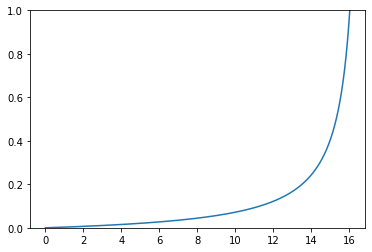

In [ ]:
c.plot_gen(c.attack(1, 0.1))

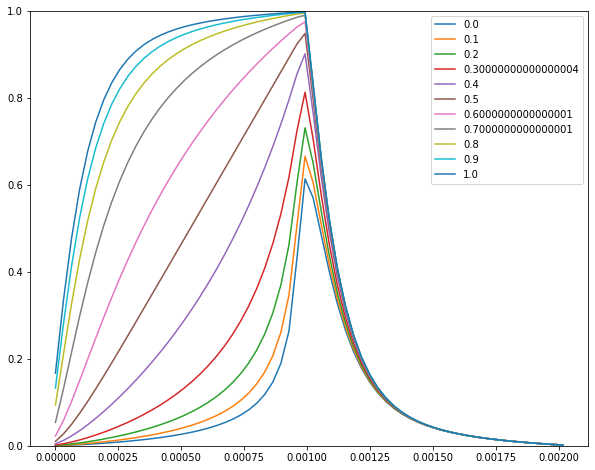

In [ ]:
plt.figure(figsize=(10, 8))
for curve in np.linspace(0, 1, 11):
    c.plot_gen(c.multi(c.attack(0.0, curve), c.decay(0.0, 1.0)), label=curve)
plt.legend()

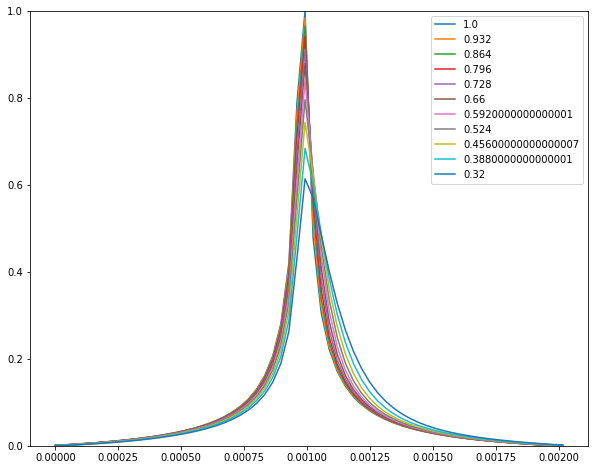

In [ ]:
plt.figure(figsize=(10, 8))
for curve in np.linspace(1, c.port_rate_to_lp_coeff(0.0), 11):
    c.plot_gen(c.multi(c.attack(0.0, 0.0), c.decay(0.0, 1.0), p=curve), label=curve)
plt.legend()

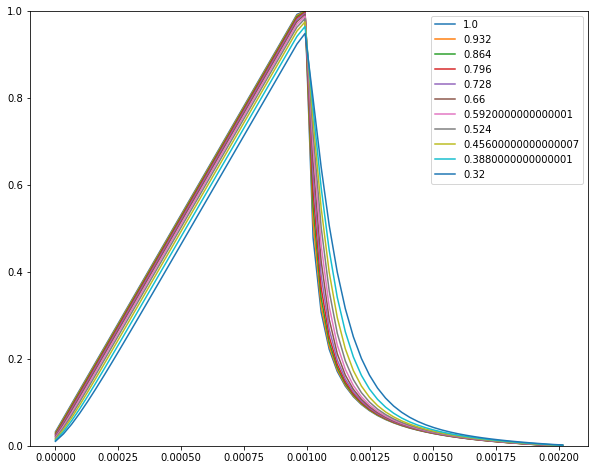

In [ ]:
plt.figure(figsize=(10, 8))
for curve in np.linspace(1, c.port_rate_to_lp_coeff(0.0), 11):
    c.plot_gen(c.multi(c.attack(0.0, 0.5), c.decay(0.0, 1.0), p=curve), label=curve)
plt.legend()

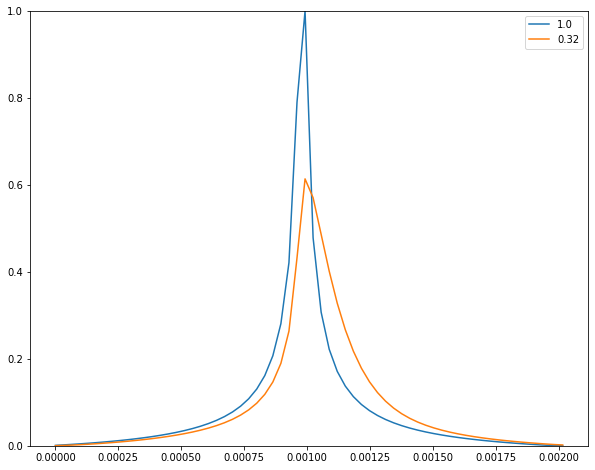

In [ ]:
plt.figure(figsize=(10, 8))
for curve in np.linspace(1, c.port_rate_to_lp_coeff(0.0), 2):
    c.plot_gen(c.multi(c.attack(0.0, 0.0), c.decay(0.0, 1.0), p=curve), label=curve)
plt.legend()